In [1]:
import os
import sys

sys.path.append("..")

import glob

import critical_loads as cl
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import rasterio
import rasterio.plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from osgeo import gdal

plt.style.use("ggplot")

In [2]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis(database="critical_loads")

Connection successful.


# Exceedances for water

Estimating exceedances for water using the SSWC and FAB models. This version of the code uses TOC concentrations interpolated for 2019, plus space- and time-varying NO3 concentrations for years since 1992. The deposition datasets used correspond to the "old" method from NILU using the BLR grid.

## 1. Select deposition series

In [3]:
# Show BLR series already in database
with pd.option_context("display.max_colwidth", -1):
    ser_grid = cl.view_dep_series(eng).query("grid == 'blr'")
    display(ser_grid)

,series_id,name,short_name,grid,description
0,1,Middel 1978-1982,7882,blr,Fordelt til BLR av NILU 2002
1,2,Middel 1992-1996,9296,blr,Fordelt til BLR av NILU 2002
2,3,Middel 1997-2001,9701,blr,Fordelt til BLR av NILU 2002
3,4,Middel 2002-2006,0206,blr,Fordelt til BLR av NILU 2008 (Wenche Aas)
24,25,Middel 2007-2011,0711,blr,Fordelt til BLR av NILU 2012 (Wenche Aas)
25,26,Middel 2012-2016,1216_old,blr,Fordelt til BLR av NILU 2017 (Wenche Aas; old method)
26,27,Middel 2012-2016 (new),1216_blrgrid,blr,Fordelt til BLR av NILU 2017 (Wenche Aas; new method)
28,29,Middel 1983-1987,8387,blr,Fordelt til BLR av NILU 2019 (Wenche Aas; old method)
29,30,Middel 1988-1992,8892,blr,Fordelt til BLR av NILU 2019 (Wenche Aas; old method)
65,66,Middel 2017-2021,1721_old,blr,Supplied by NILU in 2022 (Wenche Aas; old method)


In [4]:
# User options
cell_size = 120

# Series to use
series_dict = {
    1: ("7882", 1978, 1982),
    29: ("8387", 1983, 1987),
    30: ("8892", 1988, 1992),
    2: ("9296", 1992, 1996),
    3: ("9701", 1997, 2001),
    4: ("0206", 2002, 2006),
    25: ("0711", 2007, 2011),
    26: ("1216_old", 2012, 2016),
    66: ("1721_old", 2017, 2021),
}

## 2. Create deposition grids

In [5]:
unit = "mgpm2pyr"
pars = ["nitrogen", "sulphur"]

# Create deposition rasters
for series_id in series_dict.keys():
    for par in pars:
        print(series_id, par)
        cl.create_deposition_raster(series_id, par, unit, cell_size, eng, ndv=-1)

1 nitrogen
1 sulphur
29 nitrogen
29 sulphur
30 nitrogen
30 sulphur
2 nitrogen
2 sulphur
3 nitrogen
3 sulphur
4 nitrogen
4 sulphur
25 nitrogen
25 sulphur
26 nitrogen
26 sulphur
66 nitrogen
66 sulphur


## 3. Rasterise critical loads

In [6]:
# Read the updated values for each BLR cell (from the spatial interpolation etc.)
blr_df = pd.read_csv("updated_blr_summary.csv")
blr_df.rename({"cell_id": "Region_id"}, axis="columns", inplace=True)

# Rasterise
out_fold = r"/home/jovyan/shared/critical_loads/raster/water"
for period in series_dict.values():
    short_name = period[0]
    st_per = period[1]
    end_per = period[2]
    print(f"Processing {st_per} to {end_per}")

    cl_fold = os.path.join(out_fold, short_name)
    if not os.path.exists(cl_fold):
        os.makedirs(cl_fold)

    # Get original data from database
    req_df, opt_df, mag_df = cl.read_orig_blr_data(eng, dropna=False)

    # Update with new values from the spatial interpolation
    req_df = cl.update_required_pars(req_df, blr_df, st_per, end_per)
    opt_df = cl.estimate_optional_pars(req_df, blr_df)

    # Rasterise critical loads for water
    cl.rasterise_water_critical_loads(
        eng,
        cl_fold,
        cell_size=cell_size,
        bc0="BC0",
        req_df=req_df, # Comment out to revert to old method
        opt_df=opt_df, # Comment out to revert to old method
        df_to_csv=True,
    )

Processing 1978 to 1982


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)


Rasterising claoaa_meqpm2pyr...
Rasterising eno3_flux_meqpm2pyr...
Rasterising clminn_meqpm2pyr...
Rasterising clmaxnoaa_meqpm2pyr...
Rasterising clmaxsoaa_meqpm2pyr...
Rasterising anclimit_ueqpl...
Rasterising anclimitoaa_ueqpl...
Rasterising bc0_ueqpl...
Rasterising clmins_meqpm2pyr...
Rasters saved to:
    /home/jovyan/shared/critical_loads/raster/water/7882
Processing 1983 to 1987


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)


Rasterising claoaa_meqpm2pyr...
Rasterising eno3_flux_meqpm2pyr...
Rasterising clminn_meqpm2pyr...
Rasterising clmaxnoaa_meqpm2pyr...
Rasterising clmaxsoaa_meqpm2pyr...
Rasterising anclimit_ueqpl...
Rasterising anclimitoaa_ueqpl...
Rasterising bc0_ueqpl...
Rasterising clmins_meqpm2pyr...
Rasters saved to:
    /home/jovyan/shared/critical_loads/raster/water/8387
Processing 1988 to 1992


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)


Rasterising claoaa_meqpm2pyr...
Rasterising eno3_flux_meqpm2pyr...
Rasterising clminn_meqpm2pyr...
Rasterising clmaxnoaa_meqpm2pyr...
Rasterising clmaxsoaa_meqpm2pyr...
Rasterising anclimit_ueqpl...
Rasterising anclimitoaa_ueqpl...
Rasterising bc0_ueqpl...
Rasterising clmins_meqpm2pyr...
Rasters saved to:
    /home/jovyan/shared/critical_loads/raster/water/8892
Processing 1992 to 1996


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)


Rasterising claoaa_meqpm2pyr...
Rasterising eno3_flux_meqpm2pyr...
Rasterising clminn_meqpm2pyr...
Rasterising clmaxnoaa_meqpm2pyr...
Rasterising clmaxsoaa_meqpm2pyr...
Rasterising anclimit_ueqpl...
Rasterising anclimitoaa_ueqpl...
Rasterising bc0_ueqpl...
Rasterising clmins_meqpm2pyr...
Rasters saved to:
    /home/jovyan/shared/critical_loads/raster/water/9296
Processing 1997 to 2001


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)


Rasterising claoaa_meqpm2pyr...
Rasterising eno3_flux_meqpm2pyr...
Rasterising clminn_meqpm2pyr...
Rasterising clmaxnoaa_meqpm2pyr...
Rasterising clmaxsoaa_meqpm2pyr...
Rasterising anclimit_ueqpl...
Rasterising anclimitoaa_ueqpl...
Rasterising bc0_ueqpl...
Rasterising clmins_meqpm2pyr...
Rasters saved to:
    /home/jovyan/shared/critical_loads/raster/water/9701
Processing 2002 to 2006


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)


Rasterising claoaa_meqpm2pyr...
Rasterising eno3_flux_meqpm2pyr...
Rasterising clminn_meqpm2pyr...
Rasterising clmaxnoaa_meqpm2pyr...
Rasterising clmaxsoaa_meqpm2pyr...
Rasterising anclimit_ueqpl...
Rasterising anclimitoaa_ueqpl...
Rasterising bc0_ueqpl...
Rasterising clmins_meqpm2pyr...
Rasters saved to:
    /home/jovyan/shared/critical_loads/raster/water/0206
Processing 2007 to 2011


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)


Rasterising claoaa_meqpm2pyr...
Rasterising eno3_flux_meqpm2pyr...
Rasterising clminn_meqpm2pyr...
Rasterising clmaxnoaa_meqpm2pyr...
Rasterising clmaxsoaa_meqpm2pyr...
Rasterising anclimit_ueqpl...
Rasterising anclimitoaa_ueqpl...
Rasterising bc0_ueqpl...
Rasterising clmins_meqpm2pyr...
Rasters saved to:
    /home/jovyan/shared/critical_loads/raster/water/0711
Processing 2012 to 2016


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)


Rasterising claoaa_meqpm2pyr...
Rasterising eno3_flux_meqpm2pyr...
Rasterising clminn_meqpm2pyr...
Rasterising clmaxnoaa_meqpm2pyr...
Rasterising clmaxsoaa_meqpm2pyr...
Rasterising anclimit_ueqpl...
Rasterising anclimitoaa_ueqpl...
Rasterising bc0_ueqpl...
Rasterising clmins_meqpm2pyr...
Rasters saved to:
    /home/jovyan/shared/critical_loads/raster/water/1216_old
Processing 2017 to 2021


/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in minimum
  result = getattr(ufunc, method)(*inputs, **kwargs)


Rasterising claoaa_meqpm2pyr...
Rasterising eno3_flux_meqpm2pyr...
Rasterising clminn_meqpm2pyr...
Rasterising clmaxnoaa_meqpm2pyr...
Rasterising clmaxsoaa_meqpm2pyr...
Rasterising anclimit_ueqpl...
Rasterising anclimitoaa_ueqpl...
Rasterising bc0_ueqpl...
Rasterising clmins_meqpm2pyr...
Rasters saved to:
    /home/jovyan/shared/critical_loads/raster/water/1721_old


## 4. Calculate exceedances

### 4.1 SSWC model

Processing 1978 to 1982
Exceedance grid saved to:
    /home/jovyan/shared/critical_loads/raster/exceedance/7882/sswc_ex_meqpm2pyr_7882_120m.tif
Processing 1983 to 1987
Exceedance grid saved to:
    /home/jovyan/shared/critical_loads/raster/exceedance/8387/sswc_ex_meqpm2pyr_8387_120m.tif
Processing 1988 to 1992
Exceedance grid saved to:
    /home/jovyan/shared/critical_loads/raster/exceedance/8892/sswc_ex_meqpm2pyr_8892_120m.tif
Processing 1992 to 1996
Exceedance grid saved to:
    /home/jovyan/shared/critical_loads/raster/exceedance/9296/sswc_ex_meqpm2pyr_9296_120m.tif
Processing 1997 to 2001
Exceedance grid saved to:
    /home/jovyan/shared/critical_loads/raster/exceedance/9701/sswc_ex_meqpm2pyr_9701_120m.tif
Processing 2002 to 2006
Exceedance grid saved to:
    /home/jovyan/shared/critical_loads/raster/exceedance/0206/sswc_ex_meqpm2pyr_0206_120m.tif
Processing 2007 to 2011
Exceedance grid saved to:
    /home/jovyan/shared/critical_loads/raster/exceedance/0711/sswc_ex_meqpm2pyr_0711_1

,series_id,medium,total_area_km2,exceeded_area_km2,exceeded_area_pct,short_name
0,1,water_sswc,320585,104373,33,7882
0,29,water_sswc,320585,103419,32,8387
0,30,water_sswc,320585,87074,27,8892
0,2,water_sswc,320585,65378,20,9296
0,3,water_sswc,320585,50714,16,9701
0,4,water_sswc,320391,41700,13,0206
0,25,water_sswc,320585,34257,11,0711
0,26,water_sswc,320585,30175,9,1216_old
0,66,water_sswc,322183,37956,12,1721_old


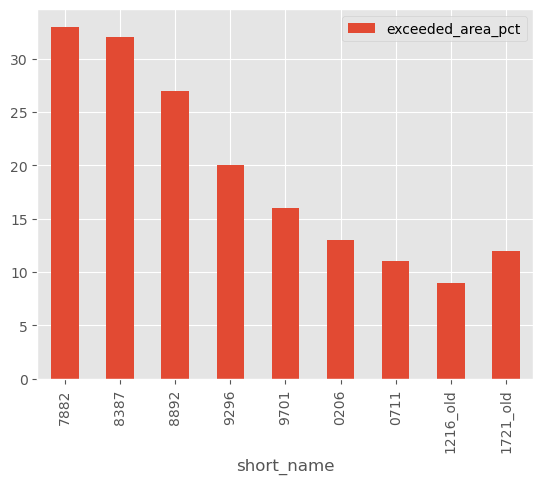

In [7]:
cl_all_fold = r"/home/jovyan/shared/critical_loads/raster/water"
ex_all_fold = r"/home/jovyan/shared/critical_loads/raster/exceedance"

df_list = []
for ser_id, period in series_dict.items():
    short_name = period[0]
    st_per = period[1]
    end_per = period[2]
    print(f"Processing {st_per} to {end_per}")

    cl_fold = os.path.join(cl_all_fold, short_name)
    ex_fold = os.path.join(ex_all_fold, short_name)
    if not os.path.exists(ex_fold):
        os.makedirs(ex_fold)

    ex_df = cl.calculate_water_exceedance_sswc(
        ser_id,
        short_name,
        cl_fold,
        ex_fold,
        cell_size=cell_size,
        bc0="BC0",
        neg_to_zero=False,
    )
    ex_df["short_name"] = short_name
    df_list.append(ex_df)

ex_df = pd.concat(df_list, axis="rows")
ex_df.plot.bar(x="short_name", y="exceeded_area_pct")
ex_df

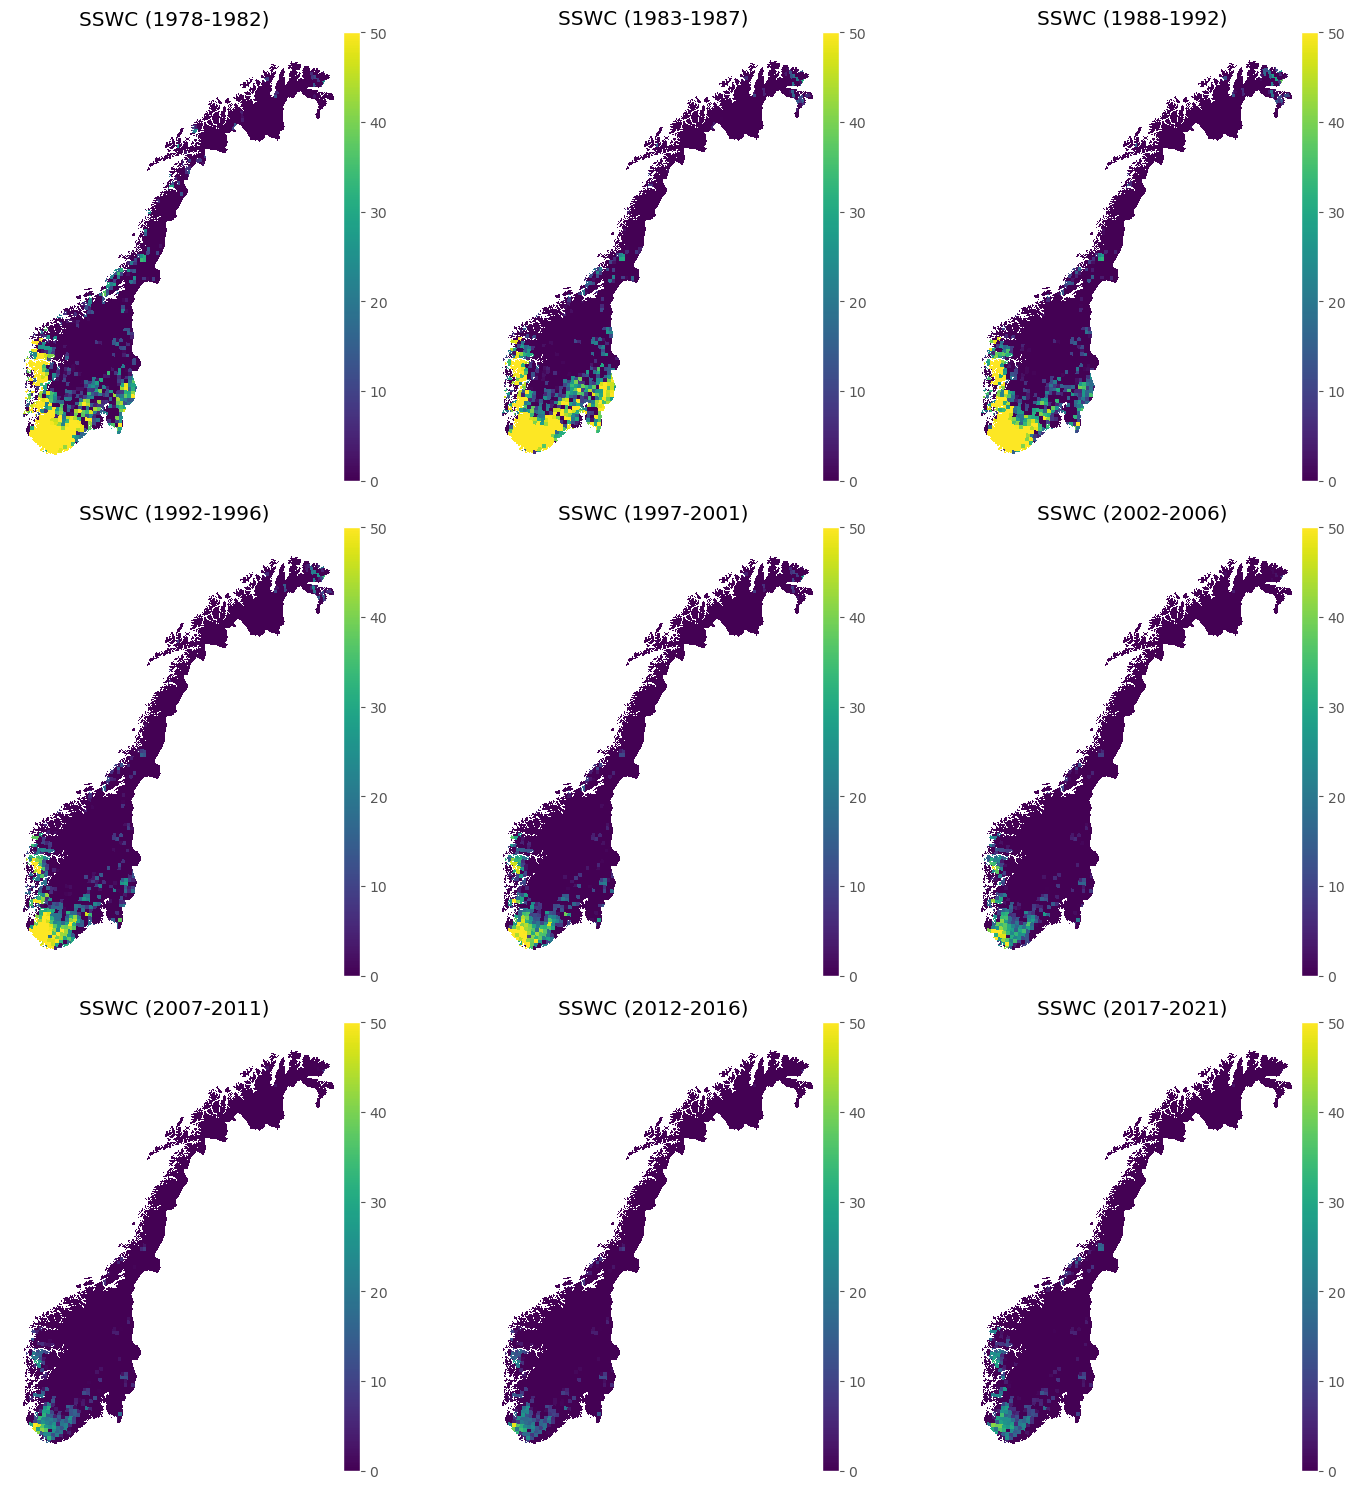

In [8]:
# Plot SSWC maps
ex_all_fold = r"/home/jovyan/shared/critical_loads/raster/exceedance"

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for idx, period in enumerate(series_dict.values()):
    short_name = period[0]
    st_per = period[1]
    end_per = period[2]

    search_path = os.path.join(ex_all_fold, short_name, "sswc_*.tif")
    fpath = glob.glob(search_path)[0]

    with rasterio.open(fpath) as src:
        data = src.read(1)
        divider1 = make_axes_locatable(axes[idx])
        cax = divider1.append_axes("right", size="5%", pad=0.05)
        im = rasterio.plot.show(
            data, ax=axes[idx], interpolation="nearest", vmin=0, vmax=50
        )
        fig.colorbar(im.images[0], cax=cax)
        axes[idx].set_title(f"SSWC ({st_per}-{end_per})")
        axes[idx].axis("off")

plt.tight_layout()

### 3.2. FAB model

Processing 1978 to 1982
Processing 1983 to 1987
Processing 1988 to 1992
Processing 1992 to 1996
Processing 1997 to 2001
Processing 2002 to 2006
Processing 2007 to 2011
Processing 2012 to 2016
Processing 2017 to 2021


,series_id,medium,total_area_km2,exceeded_area_km2,exceeded_area_pct,short_name
0,1,water_fab,320585,138492,43,7882
0,29,water_fab,320585,136634,43,8387
0,30,water_fab,320585,116361,36,8892
0,2,water_fab,320585,98049,31,9296
0,3,water_fab,320585,83120,26,9701
0,4,water_fab,320391,80434,25,0206
0,25,water_fab,320585,73796,23,0711
0,26,water_fab,320585,72601,23,1216_old
0,66,water_fab,322183,78302,24,1721_old


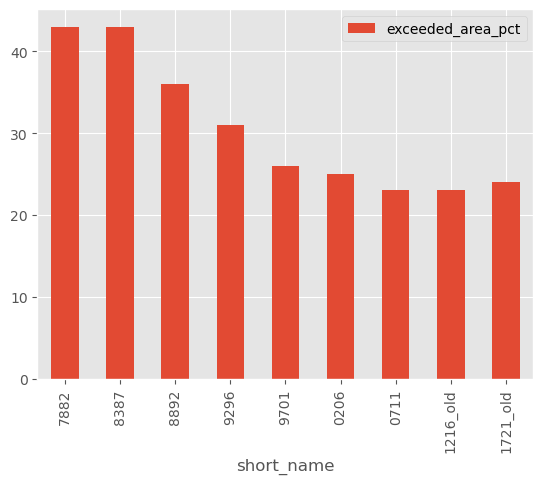

In [9]:
# Snap tiff
snap_tif = f"/home/jovyan/shared/critical_loads/raster/blr_land_mask_{cell_size}m.tif"
base_path = r"/home/jovyan/shared/critical_loads/raster"

df_list = []
for ser_id, period in series_dict.items():
    short_name = period[0]
    st_per = period[1]
    end_per = period[2]
    print(f"Processing {st_per} to {end_per}")

    # Read CL arrays
    array_dict = {}
    for par in [
        "clminn_meqpm2pyr",
        "clmaxnoaa_meqpm2pyr",
        "clmins_meqpm2pyr",
        "clmaxsoaa_meqpm2pyr",
    ]:
        # Read tif
        tif_path = os.path.join(
            base_path, "water", short_name, f"{par}_{cell_size}m.tif"
        )
        data, ndv, epsg, extent = nivapy.spatial.read_raster(tif_path)

        # Set NDV
        data[data == ndv] = np.nan

        # Add to dict
        array_dict[par] = data

    # Read dep arrays
    for par in ["ndep_mgpm2pyr", "sdep_mgpm2pyr"]:
        # Read tif
        tif_path = os.path.join(
            base_path, "deposition", f"{par}_{short_name}_{cell_size}m.tif"
        )
        data, ndv, epsg, extent = nivapy.spatial.read_raster(tif_path)
        data = data.astype(np.float32)

        # Set NDV
        data[data == ndv] = np.nan

        # Add to dict
        array_dict[par] = data

    # Extract arrays from dict
    cln_min = array_dict["clminn_meqpm2pyr"]
    cln_max = array_dict["clmaxnoaa_meqpm2pyr"]
    cls_min = array_dict["clmins_meqpm2pyr"]
    cls_max = array_dict["clmaxsoaa_meqpm2pyr"]
    dep_n = array_dict["ndep_mgpm2pyr"] / 14  # Convert to meq
    dep_s = array_dict["sdep_mgpm2pyr"] * 2 / 32.06  # Convert to meq

    # Estimate exceedances
    ex_n, ex_s, reg_id = cl.vectorised_exceed_ns_icpm(
        cln_min, cln_max, cls_min, cls_max, dep_n, dep_s
    )

    # Get exceeded area
    ex = ex_n + ex_s
    ex_area = np.count_nonzero(ex > 0) * cell_size * cell_size / 1.0e6
    nor_area = np.count_nonzero(~np.isnan(dep_s)) * cell_size * cell_size / 1.0e6
    ex_pct = 100 * ex_area / nor_area

    # Build df and tidy
    ex_df = pd.DataFrame(
        {
            "exceeded_area_km2": ex_area,
            "total_area_km2": nor_area,
            "exceeded_area_pct": ex_pct,
        },
        index=[0],
    )

    ex_df = ex_df.round(0).astype(int)
    ex_df["series_id"] = ser_id
    ex_df["medium"] = "water_fab"

    ex_df = ex_df[
        [
            "series_id",
            "medium",
            "total_area_km2",
            "exceeded_area_km2",
            "exceeded_area_pct",
        ]
    ]

    ex_df["short_name"] = short_name
    df_list.append(ex_df)

    # Save results
    # N
    n_tif = f"/home/jovyan/shared/critical_loads/raster/exceedance/{short_name}/fab_exn_meqpm2pyr_{short_name}_{cell_size}m.tif"
    cl.write_geotiff(ex_n, n_tif, snap_tif, -1, gdal.GDT_Float32)

    # S
    s_tif = f"/home/jovyan/shared/critical_loads/raster/exceedance/{short_name}/fab_exs_meqpm2pyr_{short_name}_{cell_size}m.tif"
    cl.write_geotiff(ex_s, s_tif, snap_tif, -1, gdal.GDT_Float32)

    # N+S
    ns_tif = f"/home/jovyan/shared/critical_loads/raster/exceedance/{short_name}/fab_exns_meqpm2pyr_{short_name}_{cell_size}m.tif"
    cl.write_geotiff(ex_n + ex_s, ns_tif, snap_tif, -1, gdal.GDT_Float32)

    # Exceedance 'region'
    reg_tif = f"/home/jovyan/shared/critical_loads/raster/exceedance/{short_name}/fab_ex_reg_id_{short_name}_{cell_size}m.tif"
    cl.write_geotiff(reg_id, reg_tif, snap_tif, -1, gdal.GDT_Float32)

ex_df = pd.concat(df_list, axis="rows")
ex_df.plot.bar(x="short_name", y="exceeded_area_pct")
ex_df

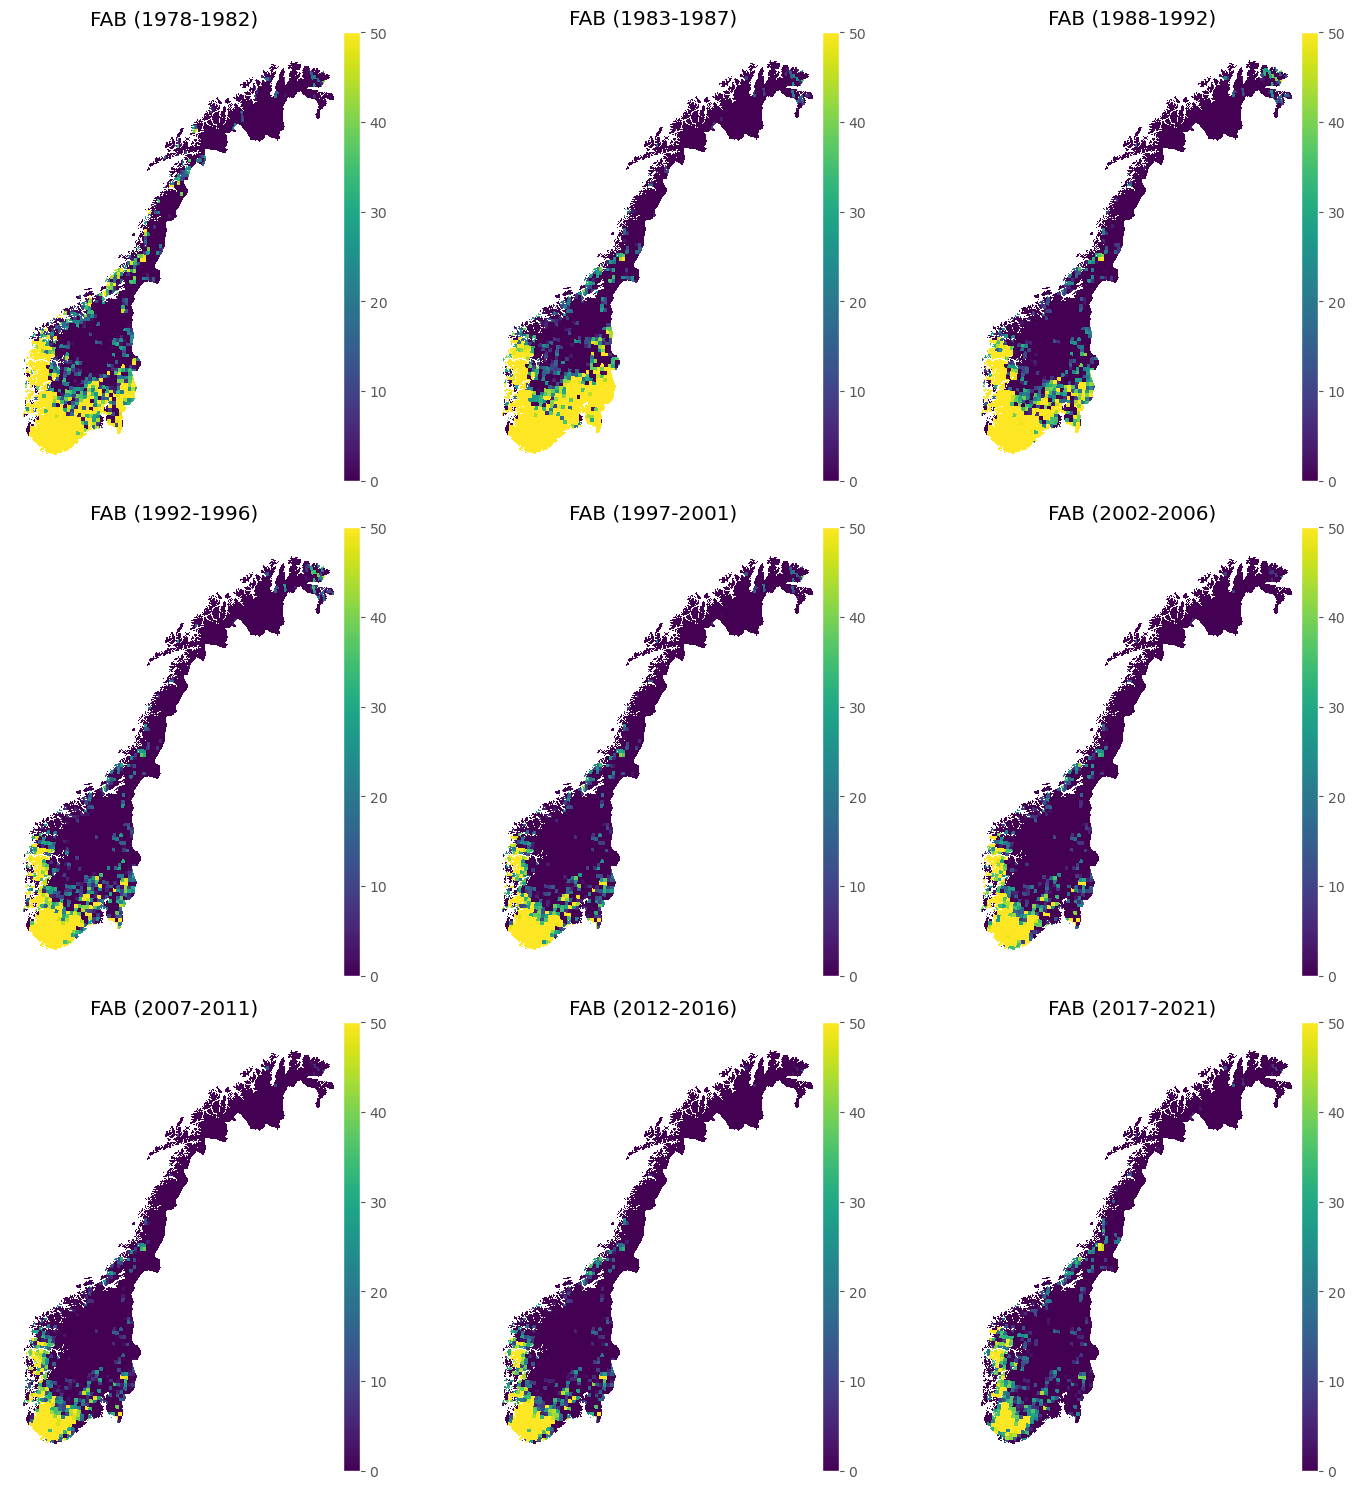

In [10]:
ex_all_fold = r"/home/jovyan/shared/critical_loads/raster/exceedance"

# Plot
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

for idx, period in enumerate(series_dict.values()):
    short_name = period[0]
    st_per = period[1]
    end_per = period[2]

    search_path = os.path.join(ex_all_fold, short_name, "fab_exns_*.tif")
    fpath = glob.glob(search_path)[0]

    with rasterio.open(fpath) as src:
        data = src.read(1)
        divider1 = make_axes_locatable(axes[idx])
        cax = divider1.append_axes("right", size="5%", pad=0.05)
        im = rasterio.plot.show(
            data,
            ax=axes[idx],
            interpolation="nearest",
            vmin=0,
            vmax=50,
        )
        fig.colorbar(im.images[0], cax=cax)
        axes[idx].set_title(f"FAB ({st_per}-{end_per})")
        axes[idx].axis("off")

plt.tight_layout()